# Satellite Image Classification

In [1]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive/MyDrive/Colab_Notebooks/CSE527_Final_Project

In [2]:
# !ls

## Librirary Installation

In [3]:
import os
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Data preprocessing

### Data Loading

In [4]:
ROOT = os.getcwd()
PATH = ROOT + "/data/data"
file_types = ('*.jpg')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

dataset = tf.keras.preprocessing.image_dataset_from_directory(PATH,
                                                              shuffle = True,
                                                              label_mode = 'categorical',
                                                              batch_size = BATCH_SIZE,
                                                              image_size = IMG_SIZE)

Found 5631 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
num_classes = len(class_names)
print(num_classes)
print(class_names)

4
['cloudy', 'desert', 'green_area', 'water']


### Visualization of image

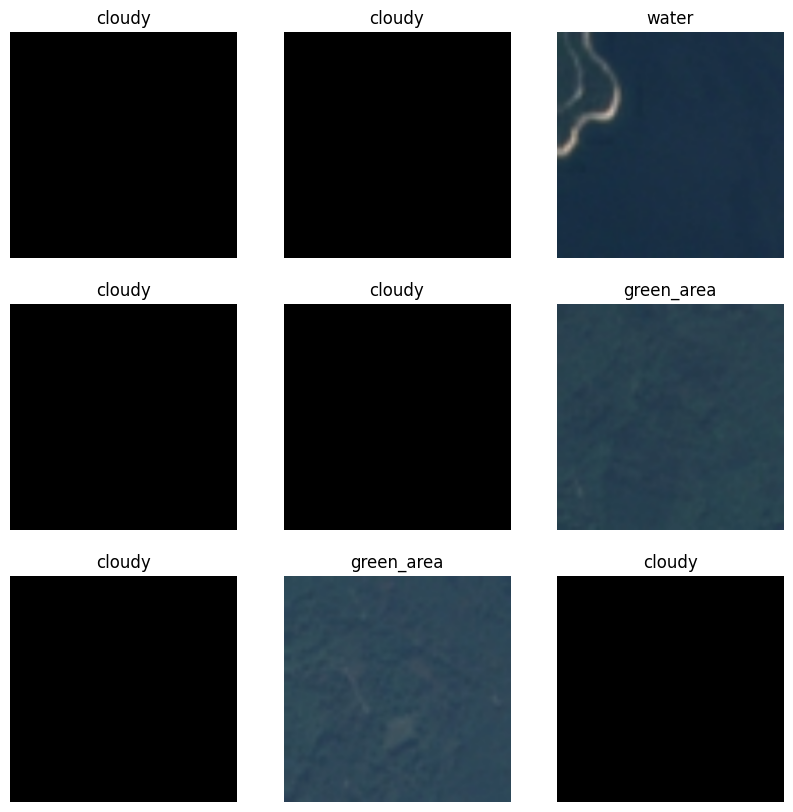

In [6]:
for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])]) # Assuming you have a list of class names
        plt.axis("off")

## Data Augmentation

In [7]:
print(tf.__version__)

2.16.1


In [8]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds

In [9]:
train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(dataset, ds_size=len(dataset))

print('Size of training dataset batch: %d' % len(train_dataset))
print('Size of validation dataset batch: %d' % len(validation_dataset))
print('Size of test dataset batch: %d' % len(test_dataset))

Size of training dataset batch: 123
Size of validation dataset batch: 35
Size of test dataset batch: 18


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(0.2, 1)
])

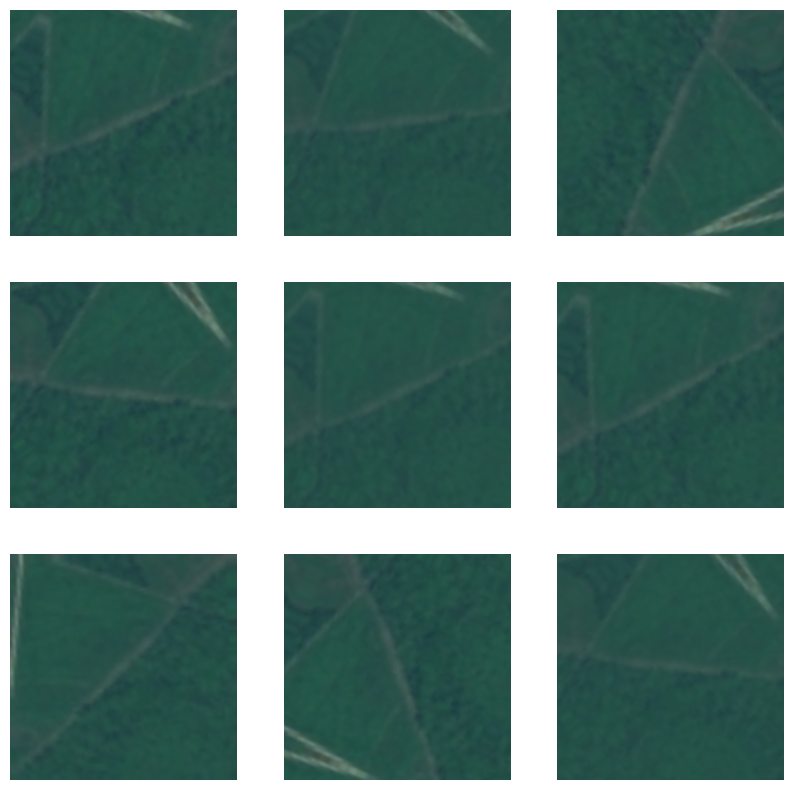

In [12]:
for image, _ in train_dataset.take(1):
 plt.figure(figsize=(10, 10))
 first_image = image[0]
 for i in range(9):
   ax = plt.subplot(3, 3, i + 1)
   augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
   plt.imshow(augmented_image[0] / 255)
   plt.axis('off')

## VGG Model

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from tensorflow.keras import models
from sklearn.metrics import roc_auc_score

### Generate model

In [14]:
def generate_model(base_model, dataset, num_classes):

    image_batch, label_batch = train_dataset.as_numpy_iterator().next()
    feature_batch = base_model(image_batch)

    base_model.trainable = True
    base_layer_count = len(base_model.layers)
    fine_tune_at = int(base_layer_count * (1/3))
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)

    prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
    prediction_batch = prediction_layer(feature_batch_average)

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [15]:
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
model = generate_model(base_model, dataset, num_classes)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 14,456,580 (55.15 MB)

 Non-trainable params: 260,160 (1016.25 KB)

### Fine Tuning

In [16]:
def build_matrics(classes_num):
    metrics = []
    metrics.append('accuracy')
    for i in range(classes_num):
        metric_name = '{}{}'.format('precision', i)
        metrics.append(tf.keras.metrics.Precision(class_id = i, name=metric_name))

    for i in range(0, classes_num):
        metric_name = '{}{}'.format('recall', i)
        metrics.append(tf.keras.metrics.Recall(class_id=i, name = metric_name))

    metrics.append(tf.keras.metrics.AUC(curve = 'ROC', name = 'roc_auc', multi_label=True, num_labels=classes_num))

    return metrics

In [17]:
metrics = build_matrics(num_classes)
metrics

['accuracy',
 <Precision name=precision0>,
 <Precision name=precision1>,
 <Precision name=precision2>,
 <Precision name=precision3>,
 <Recall name=recall0>,
 <Recall name=recall1>,
 <Recall name=recall2>,
 <Recall name=recall3>,
 <AUC name=roc_auc>]

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 14,456,580 (55.15 MB)

 Non-trainable params: 260,160 (1016.25 KB)

In [19]:
def get_precision_evaluation(history):
  precision = 0.0
  precision_begin = 2
  precision_end = precision_begin + num_classes
  for i in range(precision_begin, precision_end):
    precision += history[i]

  return precision / num_classes

def get_recall_evaluation(history):
  recall = 0.0
  recall_begin = 2 + num_classes
  recall_end = recall_begin + num_classes
  for i in range(recall_begin, recall_end):
    recall += history[i]

  return recall / num_classes

def get_f1_score(precision, recall):
  f1_score = 0.0
  if (precision + recall) != 0:
    f1_score = (2 * precision * recall) / (precision + recall)

  return f1_score

In [20]:
def check_evaluation(model):
  initial_history = model.evaluate(validation_dataset)

  initial_precision = get_precision_evaluation(initial_history)
  initial_recall = get_recall_evaluation(initial_history)
  initial_f1_score = get_f1_score(initial_precision, initial_recall)
  initial_roc_auc_index = 2 + (2 * num_classes)

  print("Initial loss: {:.2f}".format(initial_history[0]))
  print("Initial accuracy: {:.2f}".format(initial_history[1]))
  print("Initial precision: {:.2f}".format(initial_precision))
  print("Initial recall: {:.2f}".format(initial_recall))
  print("Initial F1 score: {:.2f}".format(initial_f1_score))
  print("Initial ROC: {:.2f}".format(initial_history[initial_roc_auc_index]))

In [21]:
check_evaluation(model)

35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 760ms/step - accuracy: 0.3928 - loss: 1.3023 - precision0: 0.0000e+00 - precision1: 0.8413 - precision2: 0.0609 - precision3: 0.0593 - recall0: 0.0000e+00 - recall1: 0.1582 - recall2: 0.0142 - recall3: 0.0456 - roc_auc: 0.6468
Initial loss: 1.28
Initial accuracy: 0.40
Initial precision: 0.27
Initial recall: 0.06
Initial F1 score: 0.10
Initial ROC: 0.66


### Training the model

In [22]:
initial_epochs = 30

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.8994 - loss: 0.2830 - precision0: 1.0000 - precision1: 0.9474 - precision2: 0.8840 - precision3: 0.8834 - recall0: 0.9309 - recall1: 0.9290 - recall2: 0.8517 - recall3: 0.7713 - roc_auc: 0.9743 - val_accuracy: 0.9964 - val_loss: 0.0188 - val_precision0: 1.0000 - val_precision1: 1.0000 - val_precision2: 0.9856 - val_precision3: 1.0000 - val_recall0: 1.0000 - val_recall1: 1.0000 - val_recall2: 1.0000 - val_recall3: 0.9869 - val_roc_auc: 0.9994
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.9929 - loss: 0.0224 - precision0: 1.0000 - precision1: 1.0000 - precision2: 0.9909 - precision3: 0.9825 - recall0: 1.0000 - recall1: 1.0000 - recall2: 0.9820 - recall3: 0.9912 - roc_auc: 0.9994 - val_accuracy: 0.9955 - val_loss: 0.0123 - val_precision0: 1.0000 - val_precision1: 1.0000 - val_precision2: 0.9832 - val_precision3: 1.0000 - val_recall0: 1.0000 - val_recall1: 1.0000 - val_recall2: 1.0000 - val_recall3: 0.9

### Evaluation

In [68]:
# def get_precision_histories(history):
#   precision_history = [0] * initial_epochs
#   val_precision_history = [0] * initial_epochs
#   for i in range(0, num_classes):
#     metric_name = '{}{}'.format('precision', i)
#     val_metric_name = 'val_' + metric_name
#     precision_history = [sum(x) for x in zip(precision_history, history.history[metric_name])]
#     val_precision_history = [sum(x) for x in zip(precision_history, history.history[val_metric_name])]

#   for i in range(0, initial_epochs):
#     precision_history[i] = precision_history[i] / num_classes
#     val_precision_history[i] = val_precision_history[i] / num_classes

#   return precision_history, val_precision_history

def get_precision_histories(history):
  precision_history = [0] * initial_epochs
  val_precision_history = [0] * initial_epochs
  for i in range(0, num_classes):
    metric_name = '{}{}'.format('precision', i)
    val_metric_name = 'val_' + metric_name
    precision_history = [sum(x) for x in zip(precision_history, history.history[metric_name])]
    val_precision_history = [sum(x) for x in zip(val_precision_history, history.history[val_metric_name])]

  for i in range(0, initial_epochs):
    precision_history[i] = precision_history[i] / num_classes
    val_precision_history[i] = val_precision_history[i] / num_classes

  return precision_history, val_precision_history

# def get_recall_histories(history):
#   recall_history = [0] * initial_epochs
#   val_recall_history = [0] * initial_epochs
#   for i in range(0, num_classes):
#     metric_name = '{}{}'.format('recall', i)
#     val_metric_name = 'val_' + metric_name
#     recall_history = [sum(x) for x in zip(recall_history, history.history[metric_name])]
#     val_recall_history = [sum(x) for x in zip(recall_history, history.history[val_metric_name])]

#   for i in range(0, initial_epochs):
#     recall_history[i] = recall_history[i] / num_classes
#     val_recall_history[i] = val_recall_history[i] / num_classes

#   return recall_history, val_recall_history

def get_recall_histories(history):
  recall_history = [0] * initial_epochs
  val_recall_history = [0] * initial_epochs
  for i in range(0, num_classes):
    metric_name = '{}{}'.format('recall', i)
    val_metric_name = 'val_' + metric_name
    recall_history = [sum(x) for x in zip(recall_history, history.history[metric_name])]
    val_recall_history = [sum(x) for x in zip(val_recall_history, history.history[val_metric_name])]
  print("Sum of val_recalls before dividing:", val_recall_history)

  for i in range(0, initial_epochs):
    recall_history[i] = recall_history[i] / num_classes
    val_recall_history[i] = val_recall_history[i] / num_classes

  print(val_recall_history)

  return recall_history, val_recall_history


def calculate_f1_scores(precision, recall, val_precision, val_recall):
  f1_score_temp = np.empty(len(precision))
  val_f1_score_temp = np.empty(len(f1_score_temp))
  for i in range(len(precision)):
    harmonic_avg = 0.0
    if (precision[i] + recall[i]) != 0:
      harmonic_avg = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])

    val_harmonic_avg = 0.0
    if (val_precision[i] + val_recall [i]) != 0:
      val_harmonic_avg = (2 * val_precision[i] * val_recall [i]) / (val_precision[i] + val_recall [i])

    np.put(f1_score_temp, i, harmonic_avg)
    np.put(val_f1_score_temp, i, val_harmonic_avg)
  return [f1_score_temp, val_f1_score_temp]

In [69]:

def evaluation(model, history):
    metric_name_loss = model.metrics_names[0]
    metric_name_accuracy = 'accuracy'
    acc = history.history[metric_name_accuracy]
    val_acc = history.history['val_' + metric_name_accuracy]

    loss = history.history[metric_name_loss]
    val_loss = history.history['val_' + metric_name_loss]

    roc_auc = history.history['roc_auc']
    val_roc_auc = history.history['val_roc_auc']

    precision, val_precision = get_precision_histories(history)

    recall, val_recall = get_recall_histories(history)

    f1_score, val_f1_score = calculate_f1_scores(precision, recall, val_precision, val_recall)
    return acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score


In [70]:
acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score = evaluation(model, history)


Sum of val_recalls before dividing: [3.986928105354309, 3.983108103275299, 3.990000009536743, 3.9661017060279846, 3.955017328262329, 3.966088831424713, 3.98008531332016, 3.996835470199585, 3.9931507110595703, 3.989510476589203, 3.996655523777008, 3.9965986609458923, 4.0, 3.9861591458320618, 3.9967845678329468, 3.990227997303009, 3.9906103014945984, 3.977419376373291, 3.9666666388511658, 3.9934853315353394, 3.9930796027183533, 3.953736662864685, 3.9930796027183533, 3.980066418647766, 3.9931740760803223, 3.990415334701538, 3.996825397014618, 3.9966777563095093, 3.996610164642334, 4.0]
[0.9967320263385773, 0.9957770258188248, 0.9975000023841858, 0.9915254265069962, 0.9887543320655823, 0.9915222078561783, 0.99502132833004, 0.9992088675498962, 0.9982876777648926, 0.9973776191473007, 0.999163880944252, 0.9991496652364731, 1.0, 0.9965397864580154, 0.9991961419582367, 0.9975569993257523, 0.9976525753736496, 0.9943548440933228, 0.9916666597127914, 0.9983713328838348, 0.9982699006795883, 0.98843

### Evaluation Visualization


In [71]:
def plot(acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score):
  print(val_precision)
  print(val_recall)
  print(val_f1_score)
  
  plt.figure(figsize=(10, 5))


  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
  plt.title('Training and Validation Accuracy')
  plt.xlabel('epoch')

  plt.figure(figsize=(10, 5))
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')

  plt.figure(figsize=(10, 5))
  plt.plot(precision, label='Training Precision')
  plt.plot(val_precision, label='Validation Precision')
  plt.legend(loc='lower right')
  plt.ylabel('Precision')
  plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
  plt.title('Training and Validation Precision')
  plt.xlabel('epoch')

  plt.figure(figsize=(10, 5))
  plt.plot(recall, label='Training Recall')
  plt.plot(val_recall, label='Validation Recall')
  plt.legend(loc='lower right')
  plt.ylabel('Recall')
  plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
  plt.title('Training and Validation Recall')
  plt.xlabel('epoch')

  plt.figure(figsize=(10, 5))
  plt.plot(f1_score, label='Training F1 Score')
  plt.plot(val_f1_score, label='Validation F1 Score')
  plt.legend(loc='upper left')
  plt.ylabel('F1 Score')
  plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
  plt.title('Training and Validation F1 Score')
  plt.xlabel('epoch')

  plt.figure(figsize=(10, 5))
  plt.plot(roc_auc, label='Training ROC AUC')
  plt.plot(val_roc_auc, label='Validation ROC AUC')
  plt.legend(loc='upper left')
  plt.ylabel('ROC AUC')
  plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
  plt.title('Training and Validation ROC AUC')
  plt.xlabel('epoch')

[0.9964028745889664, 0.9958053678274155, 0.9973776191473007, 0.9917218536138535, 0.9898437559604645, 0.9902722537517548, 0.9949886649847031, 0.9991987198591232, 0.998327761888504, 0.9975490123033524, 0.9991228133440018, 0.9991961419582367, 1.0, 0.9967105239629745, 0.9991582483053207, 0.9975806474685669, 0.9980842918157578, 0.9942996799945831, 0.9923728853464127, 0.9983108043670654, 0.9983333349227905, 0.989715188741684, 0.9983552694320679, 0.9951140135526657, 0.9982517510652542, 0.9974226802587509, 0.9991379380226135, 0.9991289228200912, 0.9992038160562515, 1.0]
[0.9967320263385773, 0.9957770258188248, 0.9975000023841858, 0.9915254265069962, 0.9887543320655823, 0.9915222078561783, 0.99502132833004, 0.9992088675498962, 0.9982876777648926, 0.9973776191473007, 0.999163880944252, 0.9991496652364731, 1.0, 0.9965397864580154, 0.9991961419582367, 0.9975569993257523, 0.9976525753736496, 0.9943548440933228, 0.9916666597127914, 0.9983713328838348, 0.9982699006795883, 0.9884341657161713, 0.998269

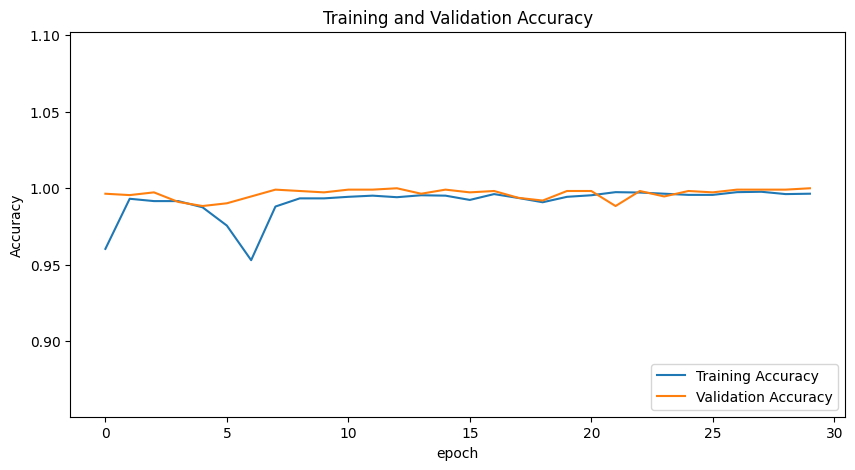

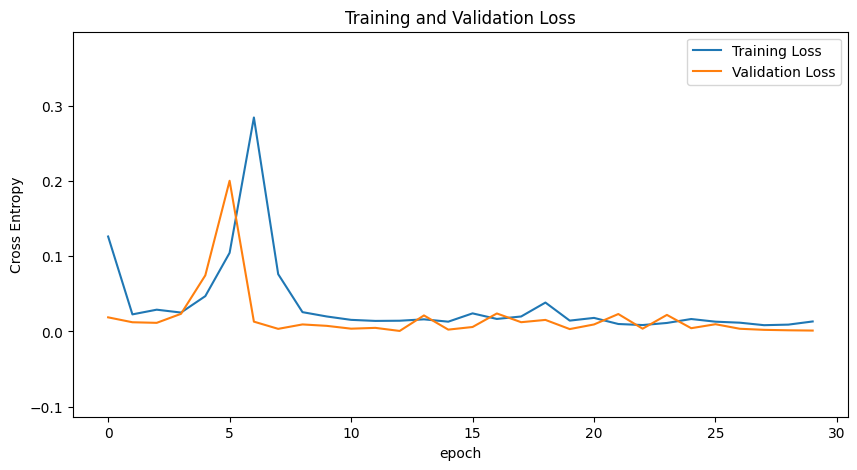

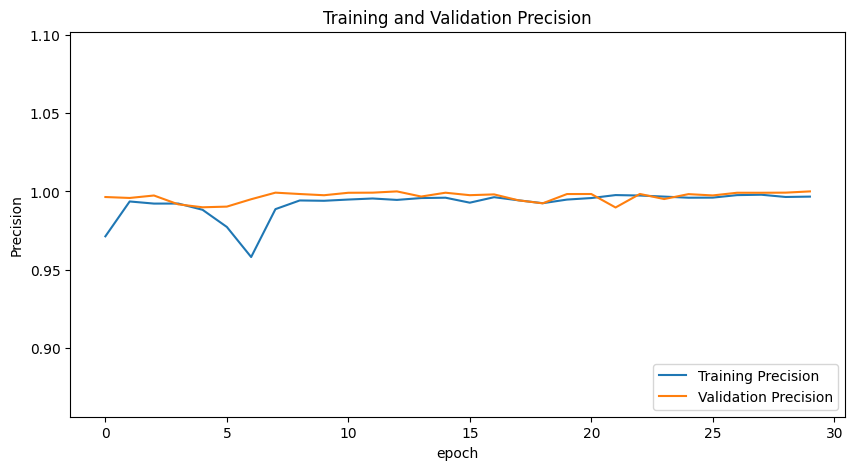

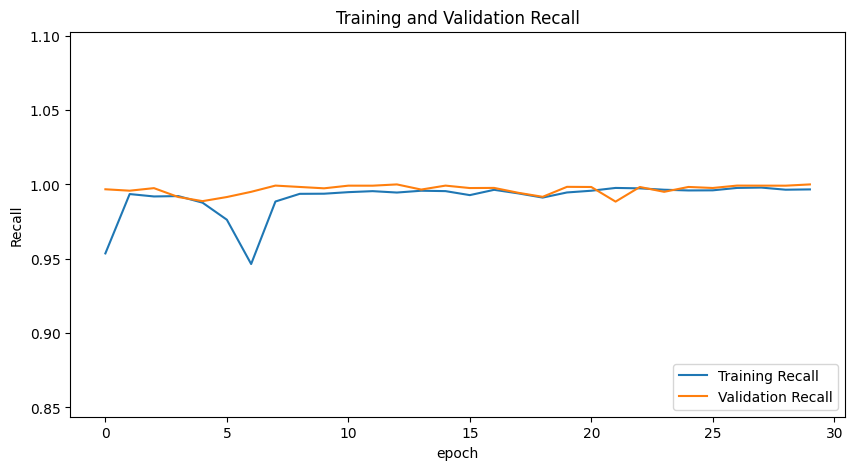

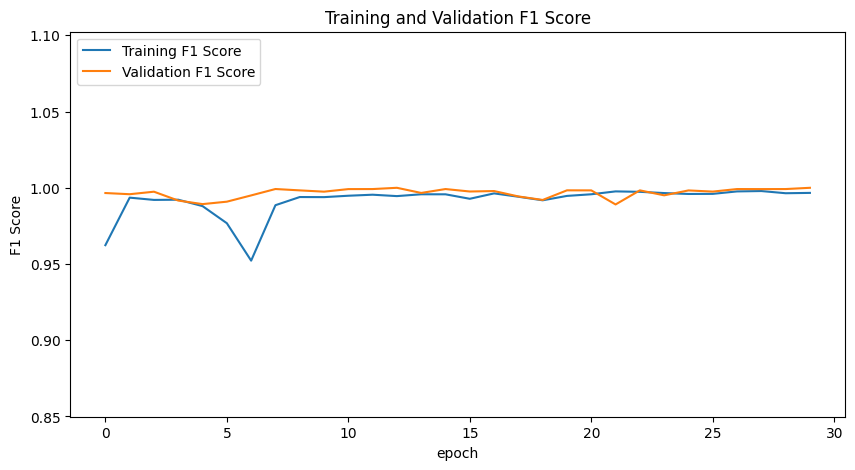

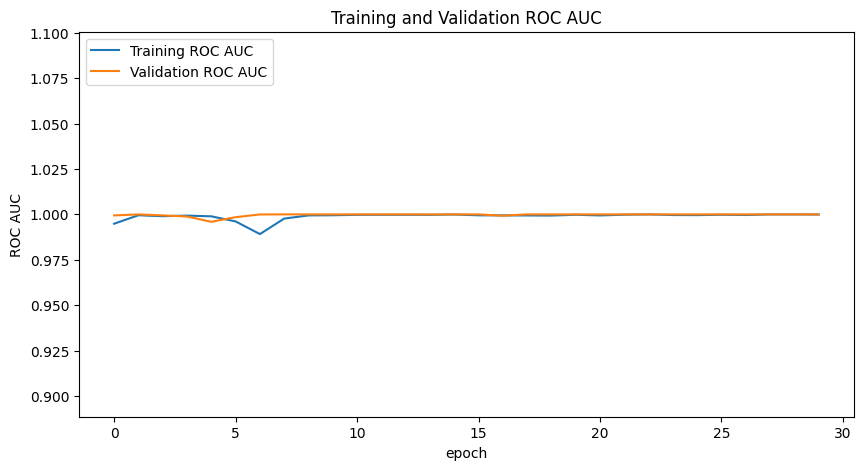

In [72]:
plot(acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score)

### Evaluation on test set

In [75]:
test_history = model.evaluate(test_dataset)

test_precision = get_precision_evaluation(test_history)
test_recall = get_recall_evaluation(test_history)
test_f1_score = get_f1_score(test_precision, test_recall)
test_roc_auc_index = 2 + (2 * num_classes)

print("test loss: {:.2f}".format(test_history[0]))
print("test accuracy: {:.2f}".format(test_history[1]))
print("test precision: {:.2f}".format(test_precision))
print("test recall: {:.2f}".format(test_recall))
print("test F1 score: {:.2f}".format(test_f1_score))
print("test ROC: {:.2f}".format(test_history[test_roc_auc_index]))

18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 707ms/step - accuracy: 0.9972 - loss: 0.0047 - precision0: 1.0000 - precision1: 1.0000 - precision2: 1.0000 - precision3: 0.9890 - recall0: 1.0000 - recall1: 1.0000 - recall2: 0.9898 - recall3: 1.0000 - roc_auc: 1.0000
test loss: 0.00
test accuracy: 1.00
test precision: 1.00
test recall: 1.00
test F1 score: 1.00
test ROC: 1.00


## MobileNetV2

In [28]:
from tensorflow.keras.applications import MobileNetV2

### Generate the model

In [29]:
base_model2 = MobileNetV2(weights='imagenet', include_top = False, input_shape=(224,224,3))
model2 = generate_model(base_model2, dataset, num_classes)
model2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 2,179,716 (8.31 MB)

 Non-trainable params: 83,392 (325.75 KB)

### Fine Tuning

In [30]:
metrics = build_matrics(num_classes)
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

In [31]:
check_evaluation(model2)

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.0989 - loss: 1.9484 - precision0: 0.0000e+00 - precision1: 0.0000e+00 - precision2: 0.0000e+00 - precision3: 0.0000e+00 - recall0: 0.0000e+00 - recall1: 0.0000e+00 - recall2: 0.0000e+00 - recall3: 0.0000e+00 - roc_auc: 0.3618
Initial loss: 1.93
Initial accuracy: 0.12
Initial precision: 0.00
Initial recall: 0.00
Initial F1 score: 0.00
Initial ROC: 0.37


### Training the model

In [32]:
initial_epochs = 30

history2 = model2.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 34s 211ms/step - accuracy: 0.9091 - loss: 0.2324 - precision0: 0.9830 - precision1: 0.9578 - precision2: 0.9037 - precision3: 0.9523 - recall0: 0.9438 - recall1: 0.8535 - recall2: 0.8704 - recall3: 0.8304 - roc_auc: 0.9790 - val_accuracy: 0.2500 - val_loss: 2.6522 - val_precision0: 0.0000e+00 - val_precision1: 0.0000e+00 - val_precision2: 0.0000e+00 - val_precision3: 0.2602 - val_recall0: 0.0000e+00 - val_recall1: 0.0000e+00 - val_recall2: 0.0000e+00 - val_recall3: 1.0000 - val_roc_auc: 0.4254
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.9944 - loss: 0.0215 - precision0: 1.0000 - precision1: 1.0000 - precision2: 0.9869 - precision3: 0.9926 - recall0: 1.0000 - recall1: 1.0000 - recall2: 0.9922 - recall3: 0.9869 - roc_auc: 0.9996 - val_accuracy: 0.2860 - val_loss: 2.6699 - val_precision0: 0.0000e+00 - val_precision1: 0.0000e+00 - val_precision2: 0.0000e+00 - val_precision3: 0.2890 - val_recall0: 0.0000e+00 - val_recall1: 0.0

### Evaluation

In [73]:
acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score = evaluation(model2, history2)


Sum of val_recalls before dividing: [1.0, 1.0, 1.004098360426724, 1.123287670314312, 1.1490384638309479, 1.004310344811529, 1.2081560362130404, 1.5506650507450104, 2.1141909062862396, 2.928505778312683, 2.7168684005737305, 3.7973563075065613, 3.925523340702057, 3.963210701942444, 3.897130846977234, 3.996402859687805, 3.9084249138832092, 3.984894275665283, 3.9300000071525574, 3.9923380613327026, 3.9934210777282715, 3.8369905948638916, 3.99676376581192, 3.996794879436493, 3.99672132730484, 3.763888895511627, 3.953947365283966, 3.996363639831543, 3.9966777563095093, 3.996212124824524]
[0.25, 0.25, 0.251024590106681, 0.280821917578578, 0.28725961595773697, 0.25107758620288223, 0.3020390090532601, 0.3876662626862526, 0.5285477265715599, 0.7321264445781708, 0.6792171001434326, 0.9493390768766403, 0.9813808351755142, 0.990802675485611, 0.9742827117443085, 0.9991007149219513, 0.9771062284708023, 0.9962235689163208, 0.9825000017881393, 0.9980845153331757, 0.9983552694320679, 0.9592476487159729,

### Evaluation Visualization

[0.06505576521158218, 0.07225300371646881, 0.3144213408231735, 0.31898970901966095, 0.3188439831137657, 0.31401074677705765, 0.5618556700646877, 0.575388602912426, 0.5898711979389191, 0.6239967867732048, 0.6064139977097511, 0.9591280668973923, 0.9824695140123367, 0.9915384650230408, 0.9781250059604645, 0.999193549156189, 0.9815634191036224, 0.9955036044120789, 0.9830645173788071, 0.9983443766832352, 0.9983108043670654, 0.9615384638309479, 0.9991582483053207, 0.9991525411605835, 0.9991749227046967, 0.953038677573204, 0.98929663002491, 0.9991610795259476, 0.9991856664419174, 0.9991987198591232]
[0.25, 0.25, 0.251024590106681, 0.280821917578578, 0.28725961595773697, 0.25107758620288223, 0.3020390090532601, 0.3876662626862526, 0.5285477265715599, 0.7321264445781708, 0.6792171001434326, 0.9493390768766403, 0.9813808351755142, 0.990802675485611, 0.9742827117443085, 0.9991007149219513, 0.9771062284708023, 0.9962235689163208, 0.9825000017881393, 0.9980845153331757, 0.9983552694320679, 0.959247

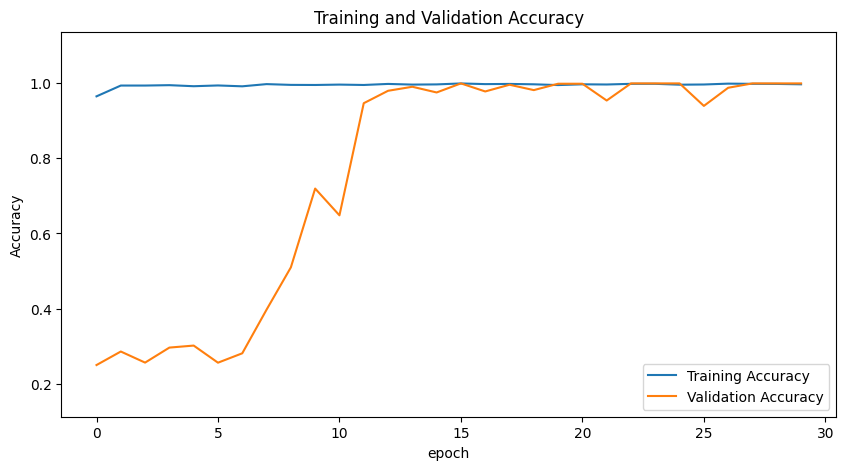

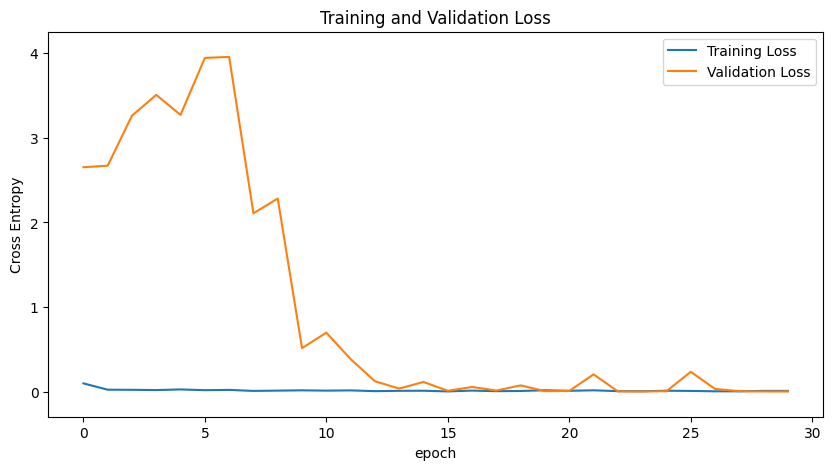

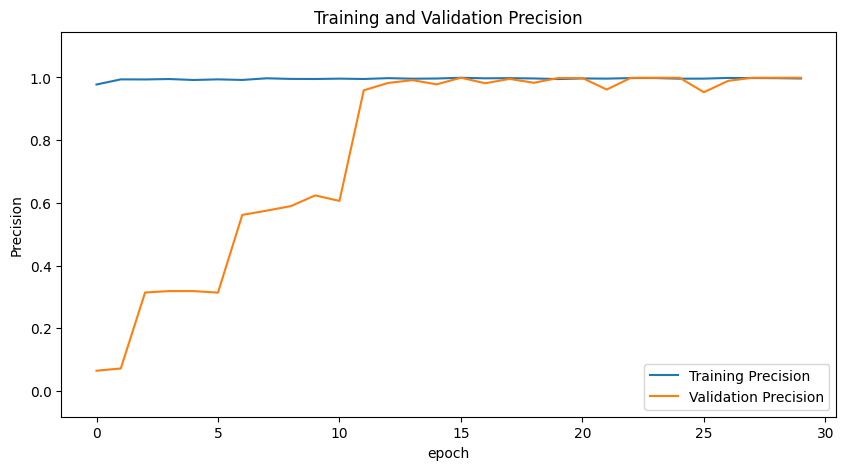

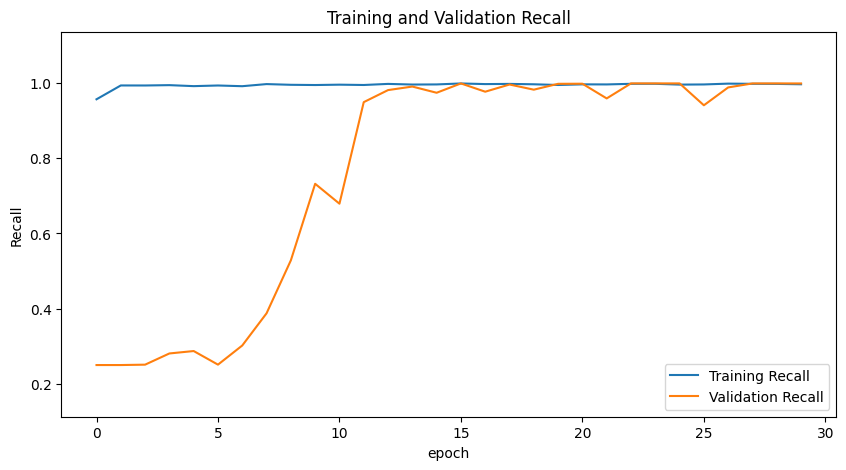

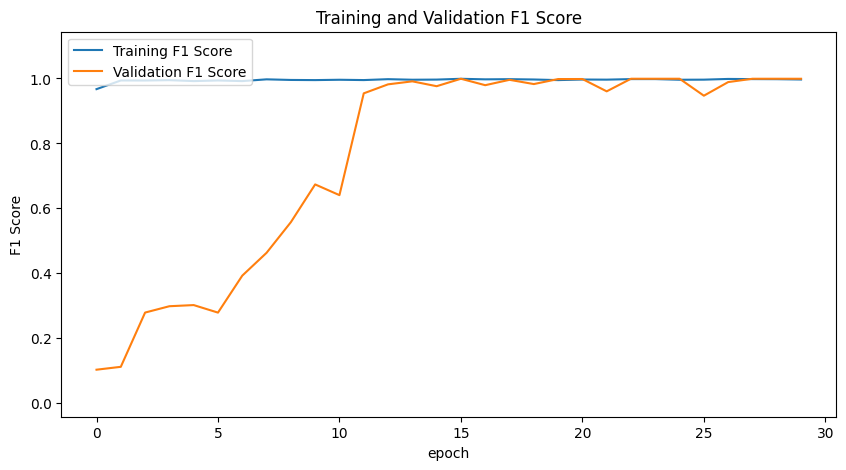

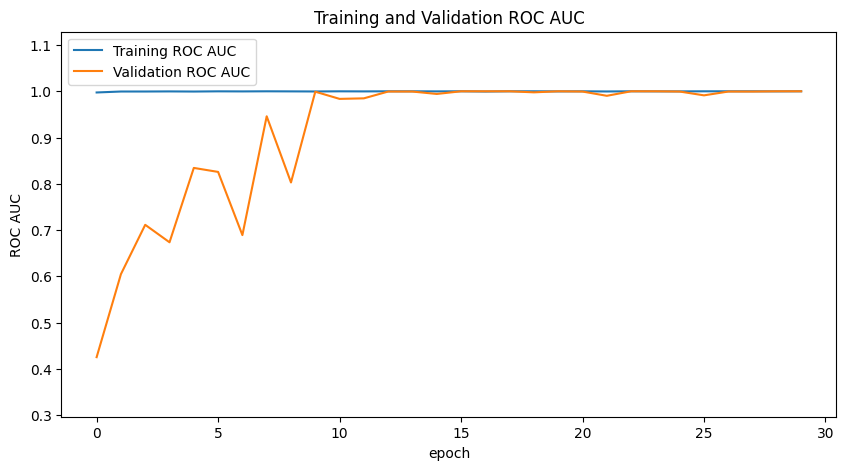

In [74]:
plot(acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score)

In [76]:
test_history = model2.evaluate(test_dataset)

test_precision = get_precision_evaluation(test_history)
test_recall = get_recall_evaluation(test_history)
test_f1_score = get_f1_score(test_precision, test_recall)
test_roc_auc_index = 2 + (2 * num_classes)

print("test loss: {:.2f}".format(test_history[0]))
print("test accuracy: {:.2f}".format(test_history[1]))
print("test precision: {:.2f}".format(test_precision))
print("test recall: {:.2f}".format(test_recall))
print("test F1 score: {:.2f}".format(test_f1_score))
print("test ROC: {:.2f}".format(test_history[test_roc_auc_index]))

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9982 - loss: 0.0141 - precision0: 1.0000 - precision1: 1.0000 - precision2: 1.0000 - precision3: 0.9922 - recall0: 1.0000 - recall1: 1.0000 - recall2: 0.9938 - recall3: 1.0000 - roc_auc: 0.9989
test loss: 0.01
test accuracy: 1.00
test precision: 1.00
test recall: 1.00
test F1 score: 1.00
test ROC: 1.00


## Xception

In [35]:
from tensorflow.keras.applications import Xception

### Generate the model

In [36]:
base_model3 = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model3 = generate_model(base_model3, dataset, num_classes)
model3.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 18,095,868 (69.03 MB)

 Non-trainable params: 2,773,808 (10.58 MB)

### Fine tuning

In [37]:
metrics = build_matrics(num_classes)
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

In [38]:
check_evaluation(model3)

35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 346ms/step - accuracy: 0.2486 - loss: 9.5972 - precision0: 0.0000e+00 - precision1: 0.1938 - precision2: 0.0000e+00 - precision3: 0.5511 - recall0: 0.0000e+00 - recall1: 0.2846 - recall2: 0.0000e+00 - recall3: 0.6821 - roc_auc: 0.5700
Initial loss: 9.56
Initial accuracy: 0.26
Initial precision: 0.19
Initial recall: 0.25
Initial F1 score: 0.22
Initial ROC: 0.58


### Training the model

In [39]:
initial_epochs = 30

history3 = model3.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 122s 934ms/step - accuracy: 0.8845 - loss: 0.4327 - precision0: 0.9111 - precision1: 0.9747 - precision2: 0.9027 - precision3: 0.8609 - recall0: 0.6969 - recall1: 0.8923 - recall2: 0.7252 - recall3: 0.6047 - roc_auc: 0.9761 - val_accuracy: 0.9929 - val_loss: 0.3324 - val_precision0: 0.0000e+00 - val_precision1: 1.0000 - val_precision2: 1.0000 - val_precision3: 0.9743 - val_recall0: 0.0000e+00 - val_recall1: 1.0000 - val_recall2: 0.9731 - val_recall3: 0.9967 - val_roc_auc: 0.9987
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 117s 951ms/step - accuracy: 0.9821 - loss: 0.0500 - precision0: 1.0000 - precision1: 0.9998 - precision2: 0.9671 - precision3: 0.9644 - recall0: 1.0000 - recall1: 0.9986 - recall2: 0.9572 - recall3: 0.9707 - roc_auc: 0.9988 - val_accuracy: 0.8795 - val_loss: 0.4022 - val_precision0: 1.0000 - val_precision1: 1.0000 - val_precision2: 1.0000 - val_precision3: 0.7033 - val_recall0: 1.0000 - val_recall1: 0.9953 - val_recall2: 0.5503 - va

### Evaluation

In [79]:
acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score = evaluation(model3, history3)


Sum of val_recalls before dividing: [2.9697744846343994, 3.5456627011299133, 3.912052094936371, 3.9736841917037964, 3.9428571462631226, 3.57051283121109, 3.9383561611175537, 3.908450722694397, 3.9966996908187866, 3.9532374143600464, 3.982304871082306, 3.9894490242004395, 3.993355453014374, 3.9111111164093018, 3.9247292280197144, 3.9324324131011963, 3.9129032492637634, 3.946308732032776, 3.793350636959076, 3.989830493927002, 3.975000023841858, 3.9863481521606445, 3.5785714387893677, 3.8231292366981506, 3.9964664578437805, 3.918644070625305, 3.9795918464660645, 3.996610164642334, 4.0, 4.0]
[0.7424436211585999, 0.8864156752824783, 0.9780130237340927, 0.9934210479259491, 0.9857142865657806, 0.8926282078027725, 0.9845890402793884, 0.9771126806735992, 0.9991749227046967, 0.9883093535900116, 0.9955762177705765, 0.9973622560501099, 0.9983388632535934, 0.9777777791023254, 0.9811823070049286, 0.9831081032752991, 0.9782258123159409, 0.986577183008194, 0.948337659239769, 0.9974576234817505, 0.9937

### Evaluation Visualization


[0.7435691356658936, 0.9258241802453995, 0.9771186411380768, 0.9946319013834, 0.9853896051645279, 0.9198795109987259, 0.9861111044883728, 0.978405311703682, 0.9991776347160339, 0.991776317358017, 0.9956760555505753, 0.9973683655261993, 0.9981818199157715, 0.9825228005647659, 0.9832802563905716, 0.983974352478981, 0.9798507392406464, 0.9875389337539673, 0.9800360053777695, 0.9975728094577789, 0.9935275018215179, 0.9968553483486176, 0.9278728663921356, 0.9650684893131256, 0.9992088675498962, 0.9812091439962387, 0.9952380955219269, 0.9991776347160339, 1.0, 1.0]
[0.7424436211585999, 0.8864156752824783, 0.9780130237340927, 0.9934210479259491, 0.9857142865657806, 0.8926282078027725, 0.9845890402793884, 0.9771126806735992, 0.9991749227046967, 0.9883093535900116, 0.9955762177705765, 0.9973622560501099, 0.9983388632535934, 0.9777777791023254, 0.9811823070049286, 0.9831081032752991, 0.9782258123159409, 0.986577183008194, 0.948337659239769, 0.9974576234817505, 0.9937500059604645, 0.99658703804016

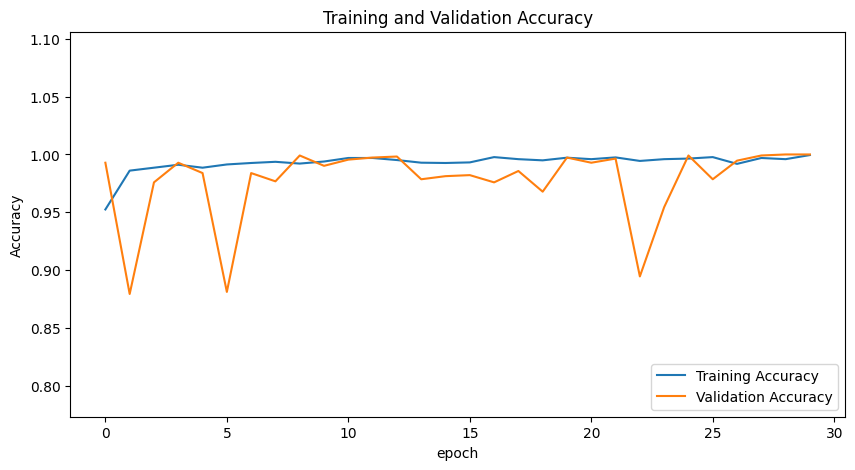

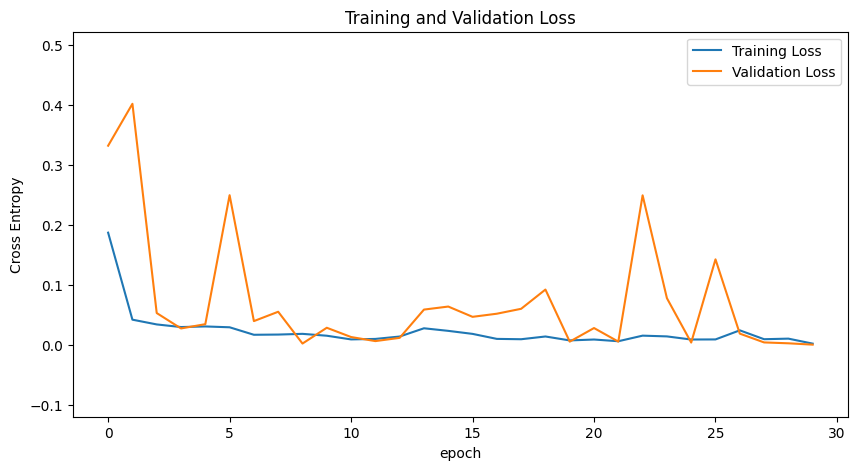

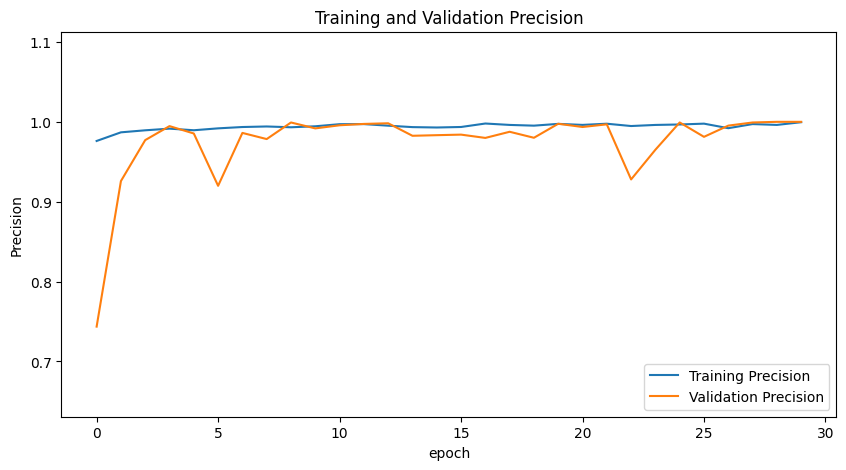

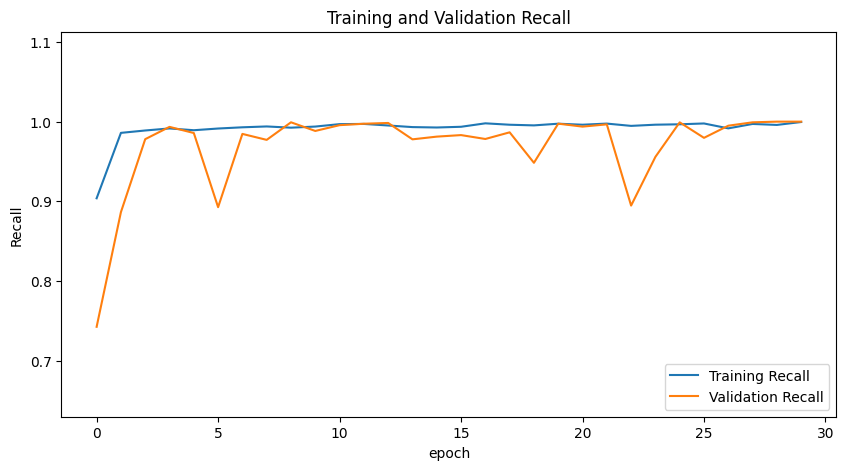

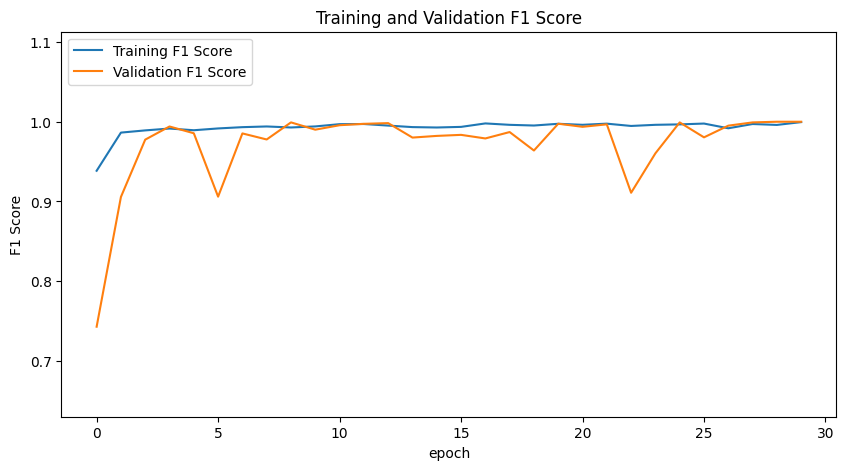

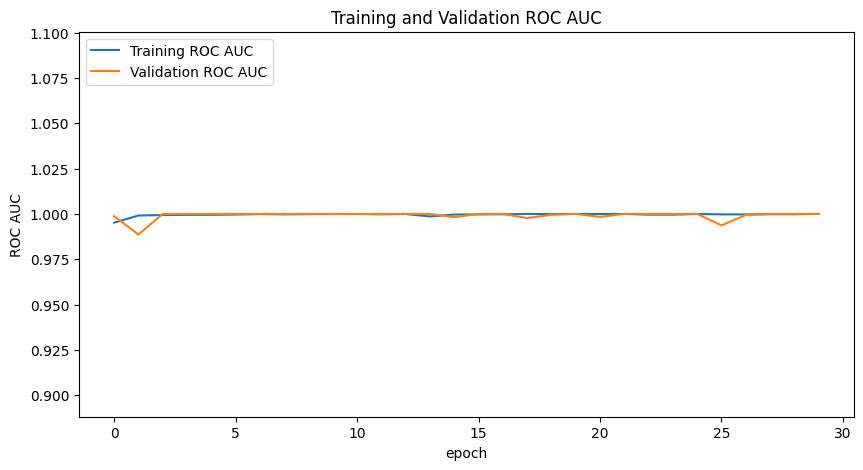

In [80]:
plot(acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score)

In [81]:
test_history = model3.evaluate(test_dataset)

test_precision = get_precision_evaluation(test_history)
test_recall = get_recall_evaluation(test_history)
test_f1_score = get_f1_score(test_precision, test_recall)
test_roc_auc_index = 2 + (2 * num_classes)

print("test loss: {:.2f}".format(test_history[0]))
print("test accuracy: {:.2f}".format(test_history[1]))
print("test precision: {:.2f}".format(test_precision))
print("test recall: {:.2f}".format(test_recall))
print("test F1 score: {:.2f}".format(test_f1_score))
print("test ROC: {:.2f}".format(test_history[test_roc_auc_index]))

18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 1.0000 - loss: 0.0025 - precision0: 1.0000 - precision1: 1.0000 - precision2: 1.0000 - precision3: 1.0000 - recall0: 1.0000 - recall1: 1.0000 - recall2: 1.0000 - recall3: 1.0000 - roc_auc: 1.0000
test loss: 0.00
test accuracy: 1.00
test precision: 1.00
test recall: 1.00
test F1 score: 1.00
test ROC: 1.00
